In [270]:
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns

import os

main_path = '/mnt/cephfs/sharedscratch/users/fshahi/Projects/Histomorphological-Phenotype-Learning'
import warnings
warnings.filterwarnings("ignore")

In [272]:
# Resolution and fold for the tile clustering and slide representations.
resolution     = 2.0
fold_number    = 4
groupby        = 'leiden_%s' % resolution

# Folder run.
dataset     = 'Meso'
additional_dataset = 'TCGA_MESO'
meta_folder     = '750K'
matching_field  = 'slides'


# Pickle files.
folds_pickle = '{}/files/pkl_{}_he_test_train_slides.pkl'.format(main_path, dataset)

# Tile representation files.
h5_complete_path   = '{}/results/BarlowTwins_3/{}/h224_w224_n3_zdim128/hdf5_{}_he_complete_filtered_metadata.h5'.format(main_path, dataset, dataset)
h5_additional_path = '{}/results/BarlowTwins_3/{}/h224_w224_n3_zdim128/hdf5_{}_he_complete_filtered_metadata.h5'.format(main_path, additional_dataset, additional_dataset)
figure_path = main_path + '/workflow/figures/HPC_figures/'
os.makedirs(figure_path, exist_ok=True)
main_cluster_path = h5_complete_path.split('hdf5_')[0]
main_cluster_path = os.path.join(main_cluster_path, meta_folder)
adatas_path       = os.path.join(main_cluster_path, 'adatas')

435 HPC: 11
55 HPC: 9


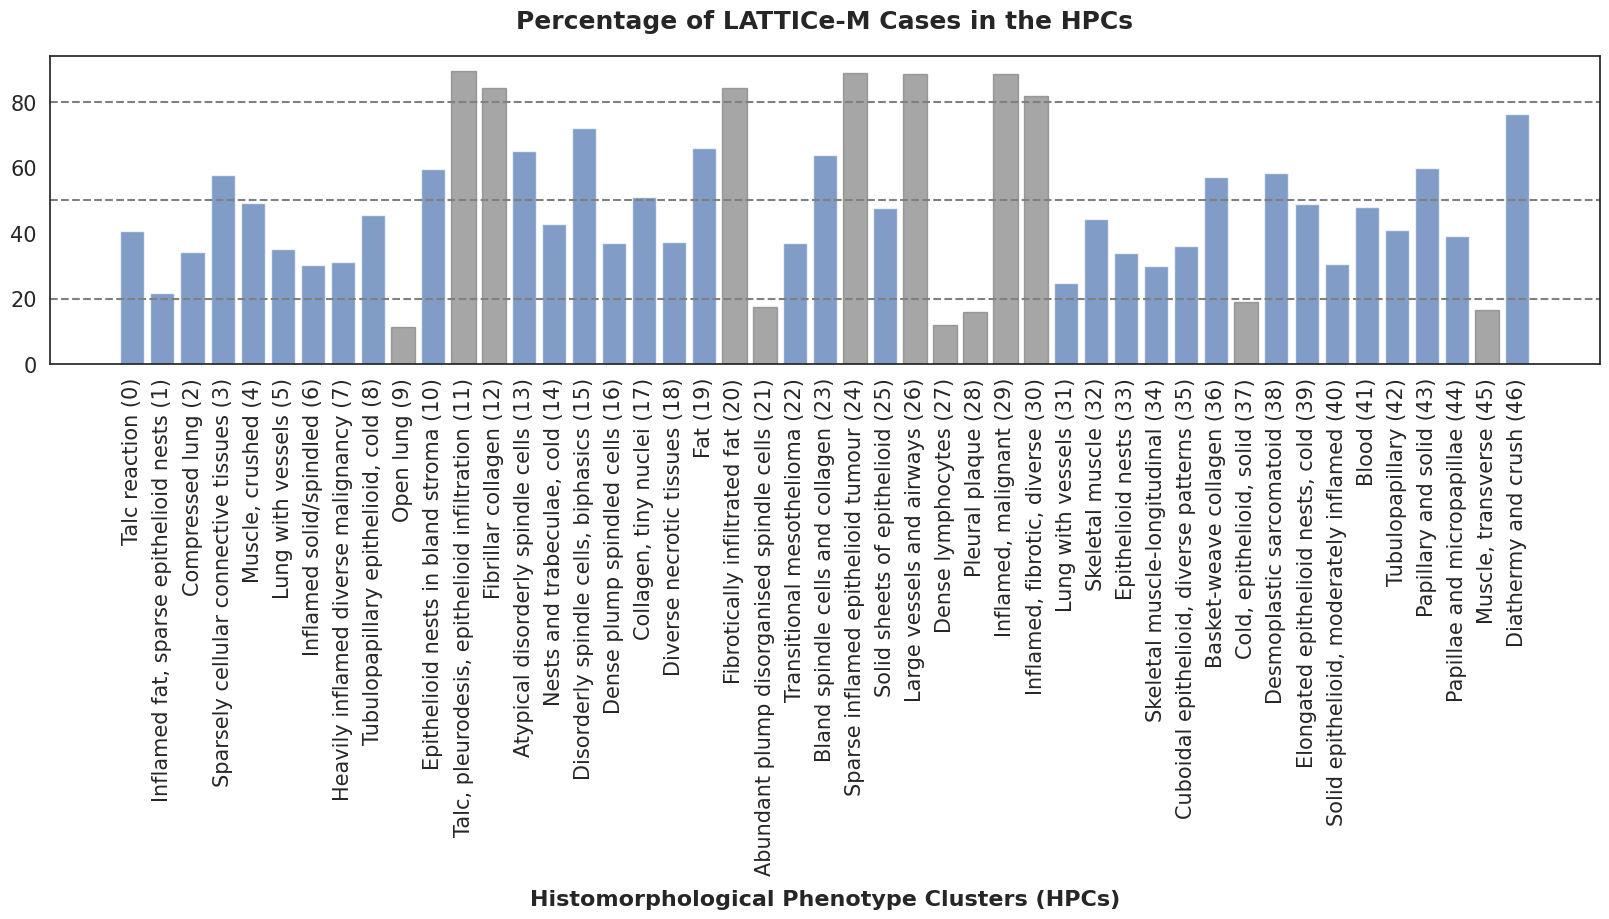

In [285]:
from skbio.stats.composition import clr_inv
meta_folder     = '750K'
df_train = pd.read_csv('{}/results/BarlowTwins_3/{}/h224_w224_n3_zdim128/{}/survival_csvs/clr_leiden_{}_fold{}_train_metadata.csv'.format(main_path, 'Meso', meta_folder , '2p0', 4), index_col=0)
df_test = pd.read_csv('{}/results/BarlowTwins_3/{}/h224_w224_n3_zdim128/{}/survival_csvs/clr_leiden_{}_fold{}_test_metadata.csv'.format(main_path, 'Meso', meta_folder , '2p0', 4), index_col=0)
annotations = pd.read_csv('{}/files/meso_annotations_750K.csv'.format(main_path), index_col=0).reset_index()


df_all = pd.concat([df_train, df_test])
leiden_clusters = [col for col in df_all.columns if col.isnumeric()]
inversed_df = pd.DataFrame(clr_inv(df_all[leiden_clusters]), columns=leiden_clusters)


sns.set_theme(style="white")
fig, ax = plt.subplots(figsize=(20,4))
hpc_df = inversed_df.copy()*100 
# at least 1% of case has the particular hpc: we call the patient HAS the HPC.
hpc_df = hpc_df > 1
hpc_df_percentages = hpc_df.astype(int).sum(axis=0)/hpc_df.shape[0]*100
# add hpc annotations to x labels
x_labels = []
for label in hpc_df_percentages.index.astype(int):
    text = annotations[annotations['HPC'] == label]['Summary'].values[0] + ' (' + str(label) + ')'
    x_labels.append(text)

ax.bar(x_labels, hpc_df_percentages.values, align='center')
plt.xticks(fontsize=15, rotation=90)
plt.yticks(fontsize=15);
ax.axhline(80, color='gray', linestyle='--')
ax.axhline(50, color='gray', linestyle='--')
ax.axhline(20, color='gray', linestyle='--')
ax.set_xlabel('Histomorphological Phenotype Clusters (HPCs)', fontsize=16, fontweight='bold', labelpad=10)
ax.set_title('Percentage of LATTICe-M Cases in the HPCs', fontsize=18, fontweight='bold', pad=20, loc='center')
for i, (v, bar) in enumerate(zip(hpc_df_percentages.values, ax.patches)):
    # if v == hpc_df_percentages.max():
    #     bar.set_alpha(1)
    if 20<v<80:
        bar.set_alpha(0.7)
    if v<20:
        # bar.set_alpha(0.3)
        bar.set_color('gray')
        bar.set_alpha(0.7)
    if v>80:
        bar.set_alpha(0.7)
        bar.set_color('gray')

print(hpc_df.sum().max(), 'HPC:', hpc_df.sum().idxmax())
print(hpc_df.sum().min(), 'HPC:', hpc_df.sum().idxmin())


In [279]:
binned.value_counts()

40-60%     15
20-40%     14
80-100%     7
0-20%       6
60-80%      5
Name: count, dtype: int64

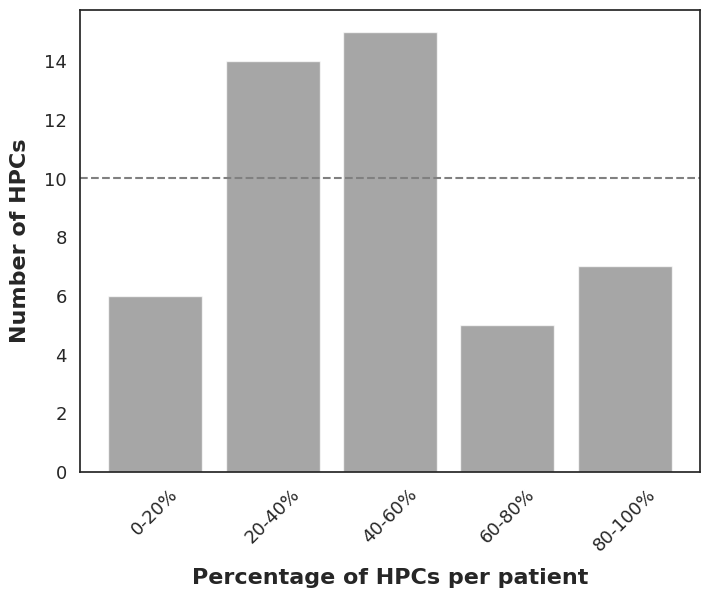

In [274]:
sns.set_theme(style="white")
# Bin the genes based on patient percentage
binned = pd.cut(hpc_df_percentages, bins=[0, 20, 40, 60, 80, 100], labels=['0-20%', '20-40%', '40-60%', '60-80%', '80-100%'], include_lowest=True)
binned_counts = binned.value_counts().sort_index()
fig, ax = plt.subplots(figsize=(8,6))
ax.bar(binned_counts.index, binned_counts.values, align='center', color='gray', alpha=0.7)
plt.xticks(fontsize=13, rotation=45);
plt.yticks(fontsize=13);
ax.set_xlabel('Percentage of HPCs per patient', fontsize=16, fontweight='bold', labelpad=10)
# ax.set_title('Number of HPCs grouped by their percentages', fontsize=18, fontweight='bold', pad=20, loc='center')
ax.set_ylabel('Number of HPCs', fontsize=16, fontweight='bold', labelpad=10)
ax.axhline(10, color='gray', linestyle='--')
# ax.set_title('Percentage of LATTICe-M Cases in the HPCs', fontsize=18, fontweight='bold', pad=20, loc='center')

Text(0.5, 1.0, 'Number of patients with a HPC percentage > 50%')

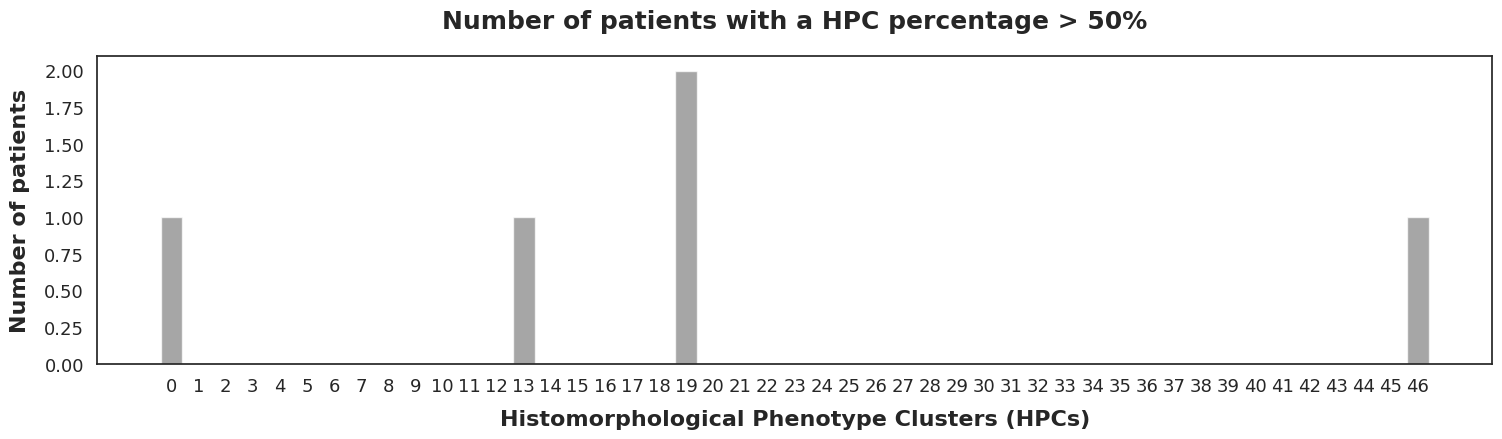

In [105]:
sns.set_theme(style="white")
fig, ax = plt.subplots(figsize=(18,4))
threshold = 50
hpc_df = inversed_df.copy()*100
temp = (hpc_df > threshold).sum(axis=0).astype(int)
ax.bar(temp.index, temp.values, align='center', color='gray', alpha=0.7)
plt.xticks(fontsize=13);
plt.yticks(fontsize=13);
ax.set_xlabel('Histomorphological Phenotype Clusters (HPCs)', fontsize=16, fontweight='bold', labelpad=10)
ax.set_ylabel('Number of patients', fontsize=16, fontweight='bold', labelpad=10)

ax.set_title('Number of patients with a HPC percentage > {}%'.format(threshold), fontsize=18, fontweight='bold', pad=20, loc='center')


#### Path-Annotation Agreement

In [54]:
import pandas as pd
import numpy as np

def clean_elements(x):
    xp = []
    for i in x:
        if not isinstance(i, float): 
            xp.append(i)
            xp = [x.strip() for x in xp]
    return xp


main_path = '/mnt/cephfs/sharedscratch/users/fshahi/Projects/Histomorphological-Phenotype-Learning'
figure_path = main_path + '/workflow/figures/HPC_figures/'
df1 = pd.read_excel(f'{main_path}/files/MM_cluster_annotation_form_v1_CR.xlsx', sheet_name='Sheet1', header=50, usecols='B:Y')
df1.iloc[-1, 0] = 46
df1.columns = [x+'_1' for x in df1.columns]
df1.rename(columns={'Cluster_1': 'HPC'}, inplace=True)

df2 = pd.read_excel(f'{main_path}/files/MM_cluster_annotation_form_v1_JLQ.xlsx', sheet_name='Sheet1', header=50, usecols='B:Y')
df2.columns = [x+'_2' for x in df2.columns]
df2.rename(columns={'Cluster_2': 'HPC'}, inplace=True)

df3 = pd.read_excel(f'{main_path}/files/MM_cluster_annotation_form_v1_SK.xlsx', sheet_name='Sheet1', header=50, usecols='B:Y')
df3.columns = [x+'_3' for x in df3.columns]
df3.rename(columns={'Cluster_3': 'HPC'}, inplace=True)

df_total = pd.merge(df1, df2, on='HPC', how='inner')
df_total = pd.merge(df_total, df3, on='HPC', how='inner')
df_total = df_total.applymap(lambda x: x.capitalize() if isinstance(x, str) else x)

In [210]:
from statsmodels.stats.inter_rater import fleiss_kappa, aggregate_raters
import dataframe_image as dfi
from scipy.stats import norm


def p_z_fscores(table):
    kappa = fleiss_kappa(table)


    N, k = table.shape
    n = np.sum(table[0])  # assumes fixed number of raters per item
    p_j = np.sum(table, axis=0) / (N * n)

    Pe_bar = np.sum(p_j ** 2)
    # print('expected agreement by chance:', Pe_bar)
    Pj3 = np.sum(p_j ** 3)
    # print('expected agreement by chance (k=3):', Pj3)

    var_kappa = (2 * (k - 1)) / (N * n * (n - 1)) * (Pe_bar - Pj3)

    # Step 4: z-score and p-value
    z = kappa / np.sqrt(var_kappa)
    p_value = 2 * (1 - norm.cdf(abs(z)))
    # get in the format of '.2f' in case of e-n power, write it
    p_value, z, kappa = f'{p_value:.2e}', f'{z:.2f}', f'{kappa:.2f}'
    return kappa, z, p_value

# inf_di = DefaultDict({'None-sparse':1, 'Mild-moderate':2, 'Marked':3})
# nec_di = DefaultDict({'None':1, 'Some':2, 'Universal':3})
# strm_cl_di = DefaultDict({'Low':1, 'Moderate':2, 'High':3})
# epi_grwth_pttr_di = DefaultDict({'Tubular':1, 'Solid':3, 'Micropapillary':2, 'Adenomaotoid':5, 'Papillary':4, 'Trabecular':6})
# spindle_arch_di = DefaultDict({'Orderly (parallel)':1, 'Less orderly (eg wavy)':2, 'Disorderly (random/storiform)':3})
# spindle_cel_di = DefaultDict({'Low':1, 'Medium':2, 'High':3})
# desmoplastic_di = DefaultDict({'Absent':1, 'Present':2})
# nucl_attypia_di = DefaultDict({'None/mild':1, 'Moderate':2, 'Severe':3})
# clust_purity_di = DefaultDict({'Low (< 50%)':1, 'Moderate (50 - 75%)':2, 'High (> 75%)':3})



kappa_value_dic, pval_dict, z_dict = dict(), dict(), dict()

# Infllamation degree.
Inflammation = df_total[['Inflammation*_1', 'Inflammation*.1_1', 'Inflammation*.2_1', 'Inflammation*_2', 'Inflammation*.1_2', 'Inflammation*.2_2', 'Inflammation*_3', 'Inflammation*.1_3', 'Inflammation*.2_3' ]]
temp = pd.DataFrame([clean_elements(x) for x in Inflammation.to_numpy()])
temp.fillna(0, inplace=True)
temp = temp.replace(dict({'None-sparse':1, 'Mild-moderate':2, 'Marked':3}))
table = aggregate_raters(temp.values)[0]
kappa_value_dic['Inflammation'], z_dict['Inflammation'], pval_dict['Inflammation'] = p_z_fscores(table)


# Necrosis degree.
Necrosis = df_total[['Necrosis**_1', 'Necrosis**.1_1', 'Necrosis**.2_1', 'Necrosis**_2', 'Necrosis**.1_2', 'Necrosis**.2_2', 'Necrosis**_3', 'Necrosis**.1_3', 'Necrosis**.2_3' ]]
for i in range(len(Necrosis)):
    for j in range(len(Necrosis.iloc[i])):
        if isinstance(Necrosis.iloc[i][j], str):
            Necrosis.iloc[i][j] = Necrosis.iloc[i][j].strip()
temp = pd.DataFrame([clean_elements(x) for x in Necrosis.to_numpy()])
temp.fillna(0, inplace=True)
temp = temp.replace(dict({'None':1, 'Some':2, 'Universal':3}))
table = aggregate_raters(temp.values)[0]
kappa_value_dic['Necrosis'], z_dict['Necrosis'], pval_dict['Necrosis'] = p_z_fscores(table)

Nuclear_atypia = df_total[['Nuclear atypia_1', 'Nuclear atypia.1_1', 'Nuclear atypia_2', 'Nuclear atypia.1_2', 'Nuclear atypia_3', 'Nuclear atypia.1_3']]
temp = pd.DataFrame([clean_elements(x) for x in Nuclear_atypia.to_numpy()])
temp.fillna(0, inplace=True)
temp = temp.replace(dict({'None/mild':1, 'Moderate':2, 'Severe':3}))
table = aggregate_raters(temp.values)[0]
kappa_value_dic['Nuclear Atypia'], z_dict['Nuclear Atypia'], pval_dict['Nuclear Atypia'] = p_z_fscores(table)


# Percentage cluster purity
cluster_purity = df_total[['Percentage cluster purity_1', 'Percentage cluster purity_2', 'Percentage cluster purity_3']]
temp = pd.DataFrame([clean_elements(x) for x in cluster_purity.to_numpy()])
temp.fillna(0, inplace=True)
temp = temp.replace(dict({'Low (< 50%)':1, 'Moderate (50 - 75%)':2, 'High (> 75%)':3}))
table = aggregate_raters(temp.values)[0]
kappa_value_dic['Cluster Purity'], z_dict['Cluster Purity'], pval_dict['Cluster Purity'] = p_z_fscores(table)

# Stromal cellularity degree.
Stromal_cellularity = df_total[['Stromal cellularity***_1', 'Stromal cellularity***_2', 'Stromal cellularity***_3']]
temp = pd.DataFrame([clean_elements(x) for x in Stromal_cellularity.to_numpy()])
temp.fillna(0, inplace=True)
temp = temp.replace(dict({'Low':1, 'Moderate':2, 'High':3}))
table = aggregate_raters(temp.values)[0]
kappa_value_dic['Stromal Cellularity'], z_dict['Stromal Cellularity'], pval_dict['Stromal Cellularity'] = p_z_fscores(table)


# epith_growth_pattern.
epith_growth_pattern = df_total[['Predominant architectural growth pattern_1', 'Second most predominant pattern_1', 'Predominant architectural growth pattern_2', 'Second most predominant pattern_2', 'Predominant architectural growth pattern_3', 'Second most predominant pattern_3']]
temp = pd.DataFrame([clean_elements(x) for x in epith_growth_pattern.to_numpy()])
temp.fillna(0, inplace=True)
temp = temp.replace(dict({'Tubular':1, 'Solid':3, 'Micropapillary':2, 'Adenomaotoid':5, 'Papillary':4, 'Trabecular':6, 'Trabecualr':6}))
table = aggregate_raters(temp.values)[0]
kappa_value_dic['Growth Pattern'], z_dict['Growth Pattern'], pval_dict['Growth Pattern'] = p_z_fscores(table)

# spindle tiles architecture.
spindle_arch = df_total[['Architecture_1', 'Architecture_2', 'Architecture_3']]
temp = pd.DataFrame([clean_elements(x) for x in spindle_arch.to_numpy()])
temp.fillna(0, inplace=True)
temp = temp.replace(dict({'Orderly (parallel)':1, 'Less orderly (eg wavy)':2, 'Disorderly (random/storiform)':3}))
table = aggregate_raters(temp.values)[0]
kappa_value_dic['Spindle Architecture'], z_dict['Spindle Architecture'], pval_dict['Spindle Architecture'] = p_z_fscores(table)

spidle_cellularity = df_total[['Cellularity_1', 'Cellularity_2', 'Cellularity_3']]
temp = pd.DataFrame([clean_elements(x) for x in spidle_cellularity.to_numpy()])
temp.fillna(0, inplace=True)
temp = temp.replace(dict({'Low':1, 'Medium':2, 'High':3}))
table = aggregate_raters(temp.values)[0]
kappa_value_dic['Spindle Cellularity'], z_dict['Spindle Cellularity'], pval_dict['Spindle Cellularity'] = p_z_fscores(table)


desmoplastic_component = df_total[['Desmoplastic_1', 'Desmoplastic_2', 'Desmoplastic_3']]
temp = pd.DataFrame([clean_elements(x) for x in desmoplastic_component.to_numpy()])
temp.fillna(0, inplace=True)
temp = temp.replace(dict({'Absent':1, 'Present':2}))
table = aggregate_raters(temp.values)[0]
kappa_value_dic['Desmoplastic Component'], z_dict['Desmoplastic Component'], pval_dict['Desmoplastic Component'] = p_z_fscores(table)

kappa_value_dic, pval_dict, z_dict


({'Inflammation': '0.32',
  'Necrosis': '0.29',
  'Nuclear Atypia': '0.40',
  'Cluster Purity': '0.23',
  'Stromal Cellularity': '0.56',
  'Growth Pattern': '0.44',
  'Spindle Architecture': '0.42',
  'Spindle Cellularity': '0.40',
  'Desmoplastic Component': '0.53'},
 {'Inflammation': '5.27e-07',
  'Necrosis': '1.44e-07',
  'Nuclear Atypia': '9.70e-10',
  'Cluster Purity': '1.31e-05',
  'Stromal Cellularity': '0.00e+00',
  'Growth Pattern': '0.00e+00',
  'Spindle Architecture': '6.88e-13',
  'Spindle Cellularity': '2.90e-12',
  'Desmoplastic Component': '0.00e+00'},
 {'Inflammation': '5.02',
  'Necrosis': '5.26',
  'Nuclear Atypia': '6.11',
  'Cluster Purity': '4.36',
  'Stromal Cellularity': '8.67',
  'Growth Pattern': '11.62',
  'Spindle Architecture': '7.18',
  'Spindle Cellularity': '6.98',
  'Desmoplastic Component': '10.88'})

In [113]:
def clean_array(x):
    xp = []
    for i in x:
        if not isinstance(i, float): 
            xp.append(i)
            xp = [x.strip() for x in xp]
    if len(xp) == 1:
        xp = xp[0]
    return xp

def add_star(temp_data, col_name, col_name_old, counts_table, keep_old=False):
    temp_data[col_name] = temp_data[col_name_old].copy()
    for idx in temp_data.index:
        x = temp_data.loc[idx, col_name_old]
        if isinstance(x, list):
            if len(x) == 0:
                temp_data.loc[idx, col_name] = ''
            else:
                if keep_old:temp_data.loc[idx, col_name] = ' | '.join(x)
                else: temp_data.loc[idx, col_name] = ''
        elif isinstance(x, str):
            count = counts_table.loc[idx, x]
            if count >= 3:
                if keep_old: temp_data.loc[idx, col_name] = x + '(*)'
                else: temp_data.loc[idx, col_name] = '*'
            else:
                if keep_old: temp_data.loc[idx, col_name] = x
                else: temp_data.loc[idx, col_name] = ''
        else:
            if keep_old: temp_data.loc[idx, col_name] = x
            else: temp_data.loc[idx, col_name] = ''
    return temp_data

def inflammation_color(val, col_name):
    x = val[col_name]
    if isinstance(x, str):
        if x == 'Marked':
            color = 'background-color: #990001'
        elif x == 'Mild-moderate':
            color = 'background-color: #e06666'
        elif x == 'None-sparse':
            color = 'background-color: #f5cbcc'
    else:
        color = 'background-color: #666666'
    
    return [color] * len(val)


def necrosis_color(val, col_name):
    x = val[col_name]
    if isinstance(x, str):
        if x == 'None':
            color = 'background-color: #f8e8e9'
        elif x == 'Some':
            color = 'background-color: #e06666'
        elif x == 'Universal':
            color = 'background-color: #660000'
    else:
        color = 'background-color: #666666'
    
    return [color] * len(val)

def nuclear_color(val, col_name):
    x = val[col_name]
    if isinstance(x, str):
        if x == 'None/mild':
            color = 'background-color: #ead1db'
        elif x == 'Moderate':
            color = 'background-color: #c27ba0'
        elif x == 'Severe':
            color = 'background-color: #751a47'
    elif isinstance(x, list):
        if len(x) < 1:
            color = ''
        else:
            color = 'background-color: #666666'
    else:
        color = ''
    return [color] * len(val)

def purity_color(val, col_name):
    x = val[col_name]
    if isinstance(x, str):
        if x == 'Low (< 50%)':
            color = 'background-color: #ea9999'
        elif x == 'Moderate (50 - 75%)':
            color = 'background-color: #ffd966'
        elif x == 'High (> 75%)':
            color = 'background-color: #93c47d'
    elif isinstance(x, list):
        if len(x) < 1:
            color = ''
        else:
            color = 'background-color: #666666'
    else:
        color = ''
    return [color] * len(val)

def stromal_color(val, col_name):
    x = val[col_name]
    if isinstance(x, str):
        if x == 'Low':
            color = 'background-color: #d0e2f3'
        elif x == 'Moderate':
            color = 'background-color: #3d85c6'
        elif x == 'High':
            color = 'background-color: #073763'
    elif isinstance(x, list):
        if len(x) < 1:
            color = ''
        else:
            color = 'background-color: #666666'
    else:
        color = ''
    return [color] * len(val)

def spindle_cel_color(val, col_name):
    x = val[col_name]
    if isinstance(x, str):
        if x == 'Low':
            color = 'background-color: #ead1db'
        elif x == 'Medium':
            color = 'background-color: #c27ba0'
        elif x == 'High':
            color = 'background-color: #751a47'
    elif isinstance(x, list):
        if len(x) < 1:
            color = ''
        else:
            color = 'background-color: #666666'
    else:
        color = ''
    return [color] * len(val)

def desmoplastic_color(val, col_name):
    x = val[col_name]
    if isinstance(x, str):
        if x == 'Absent':
            color = 'background-color: #b5d7a8'
        elif x == 'Present':
            color = 'background-color: #e06666'
    elif isinstance(x, list):
        if len(x) < 1:
            color = ''
        else:
            color = 'background-color: #666666'
    else:
        color = ''

    return [color] * len(val)


def epith_color(val, col_name):
    x = val[col_name]
    if isinstance(x, str):
        if x == 'Tubular':
            color = 'background-color: #647d93'
        elif x == 'Solid':
            color = 'background-color: #b4a7d5'
        elif x == 'Papillary':
            color = 'background-color: #f9cb9c'
    elif isinstance(x, list):
        if len(x) < 1:
            color = ''
        else:
            color = 'background-color: #666666'
    else:
        color = ''
    return [color] * len(val)

def spindle_arch_color(val, col_name):
    x = val[col_name]
    if isinstance(x, str):
        if x == 'Orderly (parallel)':
            color = 'background-color: #d9ead3'
        elif x == 'Less orderly (eg wavy)':
            color = 'background-color: #f6bc1e'
        elif x == 'Disorderly (random/storiform)':
            color = 'background-color: #b6d7a8'
    elif isinstance(x, list):
        if len(x) < 1:
            color = ''
        else:
            color = 'background-color: #666666'
    else:
        color = ''
    return [color] * len(val)

In [ ]:
col_old_names = ['Inf']
temp_data = Inflammation.copy()
df = pd.DataFrame(temp_data.mode(axis=1).apply(lambda x: clean_array(x), axis=1), columns=col_old_names)
df = add_star(df, 'Inflammation', col_old_names[-1], temp_data.apply(pd.Series.value_counts, axis=1).fillna(0))


col_old_names.append('nec')
temp_data = Necrosis.copy()
df[col_old_names[-1]] = temp_data.mode(axis=1).apply(lambda x: clean_array(x), axis=1)
df = add_star(df, 'Necrosis', col_old_names[-1], temp_data.apply(pd.Series.value_counts, axis=1).fillna(0))

col_old_names.append('nuc_atypia')
temp_data = Nuclear_atypia.copy()
df[col_old_names[-1]] = temp_data.mode(axis=1).apply(lambda x: clean_array(x), axis=1)
df = add_star(df, 'Nuclear Atypia', col_old_names[-1], temp_data.apply(pd.Series.value_counts, axis=1).fillna(0))

col_old_names.append('purity')
temp_data = cluster_purity.copy()
df[col_old_names[-1]] = temp_data.mode(axis=1).apply(lambda x: clean_array(x), axis=1)
df = add_star(df, 'Cluster Purity', col_old_names[-1], temp_data.apply(pd.Series.value_counts, axis=1).fillna(0))

col_old_names.append('strm_cl')
temp_data = Stromal_cellularity.copy()
df[col_old_names[-1]] = temp_data.mode(axis=1).apply(lambda x: clean_array(x), axis=1)
df = add_star(df, 'Stromal Cellularity', col_old_names[-1], temp_data.apply(pd.Series.value_counts, axis=1).fillna(0))

col_old_names.append('spindle_cel')
temp_data = spidle_cellularity.copy()
df[col_old_names[-1]] = temp_data.mode(axis=1).apply(lambda x: clean_array(x), axis=1)
df = add_star(df, 'Spindle Cellularity', col_old_names[-1], temp_data.apply(pd.Series.value_counts, axis=1).fillna(0))

col_old_names.append('desmoplastic')
temp_data = desmoplastic_component.copy()
df[col_old_names[-1]] = temp_data.mode(axis=1).apply(lambda x: clean_array(x), axis=1)
df = add_star(df, 'Desmoplastic Component', col_old_names[-1], temp_data.apply(pd.Series.value_counts, axis=1).fillna(0))

col_old_names.append('epith_growth')
temp_data = epith_growth_pattern.copy()
df[col_old_names[-1]] = temp_data.mode(axis=1).apply(lambda x: clean_array(x), axis=1)
df = add_star(df, 'Growth Pattern', col_old_names[-1], temp_data.apply(pd.Series.value_counts, axis=1).fillna(0), keep_old=True)

col_old_names.append('spindle_arch')
temp_data = spindle_arch.copy()
df[col_old_names[-1]] = temp_data.mode(axis=1).apply(lambda x: clean_array(x), axis=1)
df = add_star(df, 'Spindle Architecture', col_old_names[-1], temp_data.apply(pd.Series.value_counts, axis=1).fillna(0), keep_old=True)

# Style the display column but show the modified content
styled_df = df.style\
    .set_properties(**{'color': 'black', 'text-align':'center','border': '1px solid black' } )\
    .apply(inflammation_color, col_name='Inf', axis=1, subset=['Inflammation', 'Inf'])\
    .apply(necrosis_color, col_name='nec', axis=1, subset=['Necrosis', 'nec'])\
    .apply(nuclear_color, col_name='nuc_atypia', axis=1, subset=['Nuclear Atypia', 'nuc_atypia'])\
    .apply(purity_color, col_name='purity', axis=1, subset=['Cluster Purity', 'purity'])\
    .apply(stromal_color, col_name='strm_cl', axis=1, subset=['Stromal Cellularity', 'strm_cl'])\
    .apply(spindle_cel_color, col_name='spindle_cel', axis=1, subset=['Spindle Cellularity', 'spindle_cel'])\
    .apply(desmoplastic_color, col_name='desmoplastic', axis=1, subset=['Desmoplastic Component', 'desmoplastic'])\
    .apply(spindle_arch_color, col_name='spindle_arch', axis=1, subset=['Spindle Architecture', 'spindle_arch'])\
    .apply(epith_color, col_name='epith_growth', axis=1, subset=['Growth Pattern', 'epith_growth'])\
    .set_table_styles([
    dict(selector="th.col_heading",
         props=[
            #  ("writing-mode", "horizontal-tb"),
                # ('transform', 'rotateZ(-90deg)'),
                ('height', '130px'),
                ('white-space', 'normal'),
                ('word-wrap', 'break-word'),
                ('text-align', 'center'),
                ('border', '2px solid black'),
                ]),
    dict(selector="th",
         props=[('border', '2px solid black'),
                ('text-align', 'center'),
                ]),
    ])


styled_df.hide(col_old_names, axis=1)

kappa_df = pd.DataFrame(columns=styled_df.columns)
for key, value in kappa_value_dic.items():
    kappa_df.loc[0,key] = value
kappa_df.fillna(0, inplace=True)
kappa_df.index = ["Fleiss' kappa"]
styled_kappa = kappa_df.style\
    .set_properties(**{'color': 'black', 'font-weight': 'bold', 'text-align':'center', 'background-color':'lightblue','border': '1px solid black', 'border-top': '4px solid black'} )\
    .set_table_styles([{'selector': 'th', 'props': [('text-align', 'center')]}], axis=0)\
    
pval_df = pd.DataFrame(columns=styled_df.columns)
for key, value in pval_dict.items():
    pval_df.loc[0,key] = value
pval_df.fillna(0, inplace=True)
pval_df.index = ["p-value"]
styled_pval = pval_df.style\
    .set_properties(**{'color': 'black', 'font-weight': 'bold', 'text-align':'center', 'background-color':'lightblue','border': '1px solid black', 'border-top': '4px solid black'} )\
    .set_table_styles([{'selector': 'th', 'props': [('text-align', 'center')]}], axis=0)\
    
z_val_df = pd.DataFrame(columns=styled_df.columns)
for key, value in z_dict.items():
    z_val_df.loc[0,key] = value
z_val_df.fillna(0, inplace=True)
z_val_df.index = ["z-value"]
styled_z_val = z_val_df.style\
    .set_properties(**{'color': 'black', 'font-weight': 'bold', 'text-align':'center', 'background-color':'lightblue','border': '1px solid black', 'border-top': '4px solid black'} )\
    .set_table_styles([{'selector': 'th', 'props': [('text-align', 'center')]}], axis=0)\
    


styled_df.concat(styled_kappa)
styled_df.concat(styled_z_val)
styled_df.concat(styled_pval)
dfi.export(styled_df, 'figures/HPC_figures/styled_dataframe.png', table_conversion='selenium')


In [144]:
dict_colours = dict()
dict_colours['Inflammation'] = dict({'None-sparse': '#f5cbcc', 'Mild-moderate': '#e06666', 'Marked': '#990001'})
dict_colours['Necrosis'] = dict({'None': '#f8e8e9', 'Some': '#e06666', 'Universal': '#660000'})
dict_colours['Nuclear Atypia'] = dict({'None/mild': '#ead1db', 'Moderate': '#c27ba0', 'Severe': '#751a47'})
dict_colours['Cluster Purity'] = dict({'Low (< 50%)': '#ea9999', 'Moderate (50 - 75%)': '#ffd966', 'High (> 75%)': '#93c47d'})
dict_colours['Stromal Cellularity'] = dict({'Low': '#d0e2f3', 'Moderate': '#3d85c6', 'High': '#073763'})
dict_colours['Spindle Cellularity'] = dict({'Low': '#ead1db', 'Medium': '#c27ba0', 'High': '#751a47'})
dict_colours['Desmoplastic Component'] = dict({'Absent': '#b5d7a8', 'Present': '#e06666'})
dict_colours['Growth Pattern'] = dict({'Tubular': '#647d93', 'Solid': '#b4a7d5', 'Papillary': '#f9cb9c'})
dict_colours['Spindle Architecture'] = dict({'Orderly (parallel)': '#d9ead3', 'Less orderly (eg wavy)': '#f6bc1e', 'Disorderly (random/storiform)': '#b6d7a8'})

def style_legend(df):
    styles = [
        {'selector': 'th', 'props': [('color', 'black'), ('text-align', 'center')]},
        {'selector': 'th.col_heading', 'props': [('color', 'black'), ('text-align', 'center'), ('border', '2px solid black')]},
        {'selector': 'th', 'props': [('width', '130px')]}
    ]
    # take the colur from defined function previously
    def apply_color(val, col_name):
        if isinstance(val, str):
            color = dict_colours.get(col_name).get(val)
            return f'background-color: {color}'
        else:
            return ''

    col_name = df.columns[0]
    return (df.style
            .applymap(apply_color, col_name=col_name, subset=[col_name])
            .set_properties(**{
                'text-align': 'center',
                # 'font-weight': 'bold',
                'padding': '10px',
                'border': '1px solid black',
                'color': 'black',
            })
            .set_table_styles(styles).hide()
           )


legend_data = pd.DataFrame({
    'Cluster Purity': ['High (> 75%)', 'Moderate (50 - 75%)', 'Low (< 50%)'],
    # 'Inflammation': ['Marked', 'Mild-moderate', 'None-sparse'],
    # 'Necrosis': ['Universal', 'Some', 'None'],
    # 'Nuclear Atypia': ['Severe', 'Moderate', 'None/mild'],
    # 'Stromal Cellularity': ['High', 'Moderate', 'Low'],
})
styled_legend = style_legend(legend_data)
styled_legend
dfi.export(styled_legend, 'figures/HPC_figures/legend.png', table_conversion='selenium')

### MIL Based Model

In [1]:
from sklearn.metrics import roc_auc_score, average_precision_score, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

from torch import nn
import torch
import torch.nn.functional as F
import h5py
from tqdm import tqdm
import pandas as pd
import numpy as np
from skimage.transform import resize

import torch.optim as optim
import torch.nn as nn
from torch.autograd import Variable
import warnings
warnings.filterwarnings("ignore")

# Images
main_path = '/mnt/cephfs/sharedscratch/users/fshahi/Projects/Histomorphological-Phenotype-Learning'
import sys
import os
sys.path.append(main_path)
from data_manipulation.data import Data
from models.clustering.correlations import *
from models.clustering.data_processing import *
from IPython.display import clear_output
clear_output()


In [2]:
def get_scores_simple(labels, y_prob):
    scores = dict()
    labels = np.array(labels)
    y_prob = np.array(y_prob)
    scores['ROC AUC'] = roc_auc_score(y_true=list(labels), y_score=list(y_prob))
    scores['Avg. Precision'] = average_precision_score(y_true=list(labels), y_score=list(y_prob))
    tn, fp, fn, tp = confusion_matrix(labels, (y_prob>0.5)*1.0).ravel()
    scores['Sensitivity'] = tp / (tp+fn)
    scores['Specificity'] = tn / (tn+fp)
    scores['Accuracy'] = accuracy_score(labels, (y_prob>0.5)*1.0)
    return scores

class CsvBags(torch.utils.data.Dataset):
    def __init__(self, csv):
        self.csv = csv
        self.bags, self.labels = self._create_bag()

    def __len__(self):
        return len(self.bags)

    def _create_bag(self):
        bag_list = []
        label_list = []
        for bag in self.csv['slides'].unique():

            bag_df = self.csv[self.csv['slides']==bag]
            bag_list.append(torch.from_numpy(bag_df.drop(['slides', 'Meso_type'], axis=1).values).unsqueeze(1))
            # TODO: just get one label for the bag
            label_list.append(torch.from_numpy(bag_df['Meso_type'].values))
        return bag_list, label_list

    def __getitem__(self, idx):
        return self.bags[idx], self.labels[idx]
    
    def get_slide_bag(self, slide):
        bag_df = self.csv[self.csv['slides']==slide]
        bag = torch.from_numpy(bag_df.drop(['slides', 'Meso_type'], axis=1).values).unsqueeze(1)
        label = torch.from_numpy(bag_df['Meso_type'].values)
        return bag, label
    
def make_weighted_loder(data):
    from torch.utils.data import WeightedRandomSampler
    all_labels = torch.tensor([t[0].item() for t in CsvBags(data).labels], dtype=torch.long)
    class_counts = torch.bincount(all_labels)
    class_weights = 1.0 / class_counts.float()
    sample_weights = class_weights[all_labels]
    sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)
    loader = torch.utils.data.DataLoader(CsvBags(data), batch_size=1, sampler=sampler)
    return loader

In [61]:
# Attention MIL
class AttentionMIL(nn.Module):
    def __init__(self, hidden_dim, att_dim):
        super(AttentionMIL, self).__init__()
        self.hidden_dim = hidden_dim
        self.att_dim = att_dim
        self.K = 1 # dimension of the attention vector

        
        # Attention Mechanism for scoring instances
        self.attention = nn.Sequential(
            nn.Linear(self.hidden_dim, self.att_dim),
            nn.Tanh(),
            nn.Linear(self.att_dim, self.K)
        )

        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(self.hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.squeeze(0)
        x = x.squeeze(1)
        A = self.attention(x)
        A = A.transpose(1, 0)
        A = F.softmax(A, dim=1)
        C = torch.mm(A, x)
        
        # classification
        Y_prob = self.classifier(C)
        Y_hat = torch.ge(Y_prob, 0.5).float()
        return Y_prob, Y_hat, A, C



class GatedAttention(nn.Module):
    def __init__(self, input_dim, att_dim):
        super(GatedAttention, self).__init__()
        self.M = input_dim
        self.L = att_dim
        self.ATTENTION_BRANCHES = 1

        self.attention_V = nn.Sequential(
            nn.Linear(self.M, self.L), # matrix V
            nn.Tanh(),
            nn.Dropout(0.25)
        )

        self.attention_U = nn.Sequential(
            nn.Linear(self.M, self.L), # matrix U
            nn.Sigmoid(),
            nn.Dropout(0.25)
        )

        self.attention_w = nn.Linear(self.L, self.ATTENTION_BRANCHES) # matrix w (or vector w if self.ATTENTION_BRANCHES==1)

        self.classifier = nn.Sequential(
            nn.Linear(self.M*self.ATTENTION_BRANCHES, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.squeeze(0)
        x = x.squeeze(1)

        A_V = self.attention_V(x)  # KxL
        A_U = self.attention_U(x)  # KxL
        A = self.attention_w(A_V * A_U) # element wise multiplication # KxATTENTION_BRANCHES
        A = torch.transpose(A, 1, 0)  # ATTENTION_BRANCHESxK
        A = F.softmax(A, dim=1)  # softmax over K

        Z = torch.mm(A, x)  # ATTENTION_BRANCHESxM

        Y_prob = self.classifier(Z)
        Y_hat = torch.ge(Y_prob, 0.4).float()

        return Y_prob, Y_hat, A, Z

In [4]:
dataset = 'Meso'
h5_complete_path   = '{}/results/BarlowTwins_3/{}/h224_w224_n3_zdim128/hdf5_{}_he_complete_filtered_metadata.h5'.format(main_path, dataset, dataset)
frame, dims, rest = representations_to_frame(h5_complete_path, meta_field='Meso_type', rep_key='z_latent')


additional_dataset = 'TCGA_MESO'
h5_additional_path = '{}/results/BarlowTwins_3/{}/h224_w224_n3_zdim128/hdf5_{}_he_complete_filtered_metadata.h5'.format(main_path, additional_dataset, additional_dataset)
frame_additional, dims_additional, rest_additional = representations_to_frame(h5_additional_path, meta_field='Meso_type', rep_key='z_latent')

Loading representations: /mnt/cephfs/sharedscratch/users/fshahi/Projects/Histomorphological-Phenotype-Learning/results/BarlowTwins_3/Meso/h224_w224_n3_zdim128/hdf5_Meso_he_complete_filtered_metadata.h5
Keys: <KeysViewHDF5 ['HB_score', 'Meso_type', 'N_stage', 'Sex', 'TNM_Stage', 'T_Stage', 'age', 'case_Id', 'chest_wall_involvement', 'confident_diagnosis', 'desmoplastic_component', 'diaphragm_involvement', 'haemoglobin', 'hist_subtype', 'img_h_latent', 'img_z_latent', 'indexes', 'labels', 'lung_involvement', 'original_set', 'os_event_data', 'os_event_ind', 'patterns', 'recurrence', 'rib_involvement', 'samples', 'side', 'slides', 'smoking_history', 'tiles', 'time_to_recurrence', 'type', 'wcc_score']>
Loading representations: /mnt/cephfs/sharedscratch/users/fshahi/Projects/Histomorphological-Phenotype-Learning/results/BarlowTwins_3/TCGA_MESO/h224_w224_n3_zdim128/hdf5_TCGA_MESO_he_complete_filtered_metadata.h5
Keys: <KeysViewHDF5 ['Meso_type', 'age_at_diagnosis', 'age_at_index', 'ajcc_patho

In [17]:
# Data packing for MIL (Just one fold)
csv_data = frame.iloc[:,0:128]
csv_data['Meso_type'] = frame['Meso_type'].astype(float)
csv_data['slides'] = frame['slides']
ratio = 0.8
train_df_slides = np.random.choice(csv_data['slides'].unique(), size=int(len(csv_data['slides'].unique())*ratio), replace=False)
test_df_slides = list(set(csv_data['slides'].unique()) - set(train_df_slides))
train_df = csv_data[csv_data['slides'].isin(train_df_slides)]
test_df = csv_data[csv_data['slides'].isin(test_df_slides)]
print(f'SIZE: Train slides: {len(train_df_slides)} - Test slides: {len(test_df_slides)}', f'| Train samples: {len(train_df)} - Test samples: {len(test_df)}')


csv_data_additional = frame_additional.iloc[:,0:128]
csv_data_additional['Meso_type'] = frame_additional['type']
csv_data_additional['Meso_type'] = csv_data_additional['Meso_type'].replace({'Epithelioid': 0, 'Sarcomatoid': 1, 'Biphasic': 1}).astype(float)
csv_data_additional['slides'] = frame_additional['slides']

SIZE: Train slides: 2756 - Test slides: 690 | Train samples: 2590173 - Test samples: 649766


In [18]:
# takes time :( ->for Meso Data: 14 minutes
# train_loader = torch.utils.data.DataLoader(CsvBags(train_df), batch_size=1, shuffle=True)
# test_loader = torch.utils.data.DataLoader(CsvBags(test_df), batch_size=1, shuffle=True)
train_loader = make_weighted_loder(train_df)
test_loader = make_weighted_loder(test_df)
csv_loader_additional = make_weighted_loder(csv_data_additional)


In [62]:
# Training Settings
input_dim = 128  # Dimension of each instance's feature vector
hidden_dim = 64  # Dimension of the hidden layer
# model = AttentionMIL(input_dim, hidden_dim)
model = GatedAttention(input_dim, hidden_dim)
# Training settings
learning_rate = 1e-4
num_epochs = 30
scores = pd.DataFrame()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.5)


In [64]:
# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.
    train_error = 0.

    predictions, probs = [], []
    labels = []
    for instances, label in train_loader:
        num_tiles = instances.shape[1]
        instances = instances.float()
        # TODO: just get one label for the bag
        label = label.squeeze(0)[0].unsqueeze(0).float()
        optimizer.zero_grad()
        y_prob, y_hat, attention_score, weighted_instances = model(instances)

        loss = F.binary_cross_entropy(y_prob.squeeze(0), label)
        train_loss += loss.item()

        predictions.append(int(y_hat))
        labels.append(int(label))
        probs.append(y_prob.item())

        loss.backward()
        optimizer.step()
        
    
    train_loss /= len(train_loader)
    print('Train Set, Epoch: {}, Loss: {:.5f}'.format(epoch, train_loss))
    # get_scores_simple(labels, probs)

    # Test loop
    with torch.no_grad():
        model.eval()
        predictions, probs = [], []
        labels = []
        for instances, label in test_loader:
            instances = instances.float()
            # TODO: just get one label for the bag
            label = label.squeeze(0)[0].unsqueeze(0).float()
            y_prob, y_hat, attention_score, weighted_instances = model(instances)

            predictions.append(int(y_hat))
            labels.append(int(label))
            probs.append(y_prob.item())

        test_acc = accuracy_score(labels, predictions)*100
        print('Test Set, Accuracy: {:.4f}%'.format(test_acc))
        get_scores_simple(labels, probs)
        print('-----------------------------------------------------------------------------')

        scr_dict = pd.DataFrame([get_scores_simple(labels, probs)])
        scores = pd.concat([scores, scr_dict], ignore_index=True)


    # evaluate on the additional dataset
    with torch.no_grad():
        model.eval()
        predictions, probs = [], []
        labels = []
        for instances, label in csv_loader_additional:
            instances = instances.float()
            label = label.squeeze(0)[0].unsqueeze(0).float()
            y_prob, y_hat, attention_score, weighted_instances = model(instances)
            predictions.append(int(y_hat))
            labels.append(int(label))
            probs.append(y_prob.item())
        val_acc = accuracy_score(labels, predictions)*100
        print('Additional Set, Accuracy: {:.4f}%'.format(val_acc))
        get_scores_simple(labels, probs)
        print('-----------------------------------------------------------------------------')
        # scr_dict_additional = pd.DataFrame([get_scores_simple(labels, probs)])
        # display(scr_dict_additional)
        # scores_additional = pd.concat([scores, scr_dict_additional], ignore_index=True)

    scheduler.step(val_acc)
    
# Save the model
from copy import deepcopy
model_trained = deepcopy(model)


print(scores)
df_mean = scores.mean().apply(lambda x: np.round(x,2))
df_std = scores.std().apply(lambda x: np.round(x,2))
(df_mean.astype(str) + ' ± ' + df_std.astype(str)).reset_index()

Train Set, Epoch: 0, Loss: 0.45472
Test Set, Accuracy: 77.5362%
-----------------------------------------------------------------------------
Additional Set, Accuracy: 61.6279%
-----------------------------------------------------------------------------
Train Set, Epoch: 1, Loss: 0.40093
Test Set, Accuracy: 83.3333%
-----------------------------------------------------------------------------
Additional Set, Accuracy: 66.2791%
-----------------------------------------------------------------------------
Train Set, Epoch: 2, Loss: 0.41248
Test Set, Accuracy: 78.9855%
-----------------------------------------------------------------------------
Additional Set, Accuracy: 75.5814%
-----------------------------------------------------------------------------
Train Set, Epoch: 3, Loss: 0.40213
Test Set, Accuracy: 83.9130%
-----------------------------------------------------------------------------
Additional Set, Accuracy: 56.9767%
----------------------------------------------------------

KeyboardInterrupt: 

In [67]:
# Save the model
from copy import deepcopy
model_trained = deepcopy(model)
# save the model
folder_path = '/nfs/home/users/fshahi/Projects/Histomorphological-Phenotype-Learning/workflow/mil_results/'
os.makedirs(folder_path, exist_ok=True)
model_path = os.path.join(folder_path, 'GatedAttention_{}_{}.pth'.format(dataset, additional_dataset))
torch.save(model_trained.state_dict(), model_path)
# Save the scores
scores_path = os.path.join(folder_path, 'GatedAttention_{}_{}_scores.csv'.format(dataset, additional_dataset))
scores.to_csv(scores_path, index=False)
# score_path_add = os.path.join(folder_path, 'GatedAttention_{}_{}_scores_additional.csv'.format(dataset, additional_dataset))
# scores_additional.to_csv(score_path_add, index=False)


#### Attention Scored Heatmap

In [20]:
# data = Data(dataset='TCGA_MESO', marker='he', patch_h=224, patch_w=224, n_channels=3, batch_size=64, project_path=main_path, load=True)
data = Data(dataset='Meso', marker='he', patch_h=224, patch_w=224, n_channels=3, batch_size=64, project_path=main_path, load=True)
data_dicts = dict()

data_dicts['train'] = data.training.images
data_dicts['valid'] = data.validation.images
data_dicts['test']  = data.test.images

Meso
/mnt/cephfs/sharedscratch/users/fshahi/Projects/Histomorphological-Phenotype-Learning/datasets/Meso/he/patches_h224_w224/hdf5_Meso_he_train.h5


		Whole Slide Image Resolution MESO_8_16: (1836, 3404)


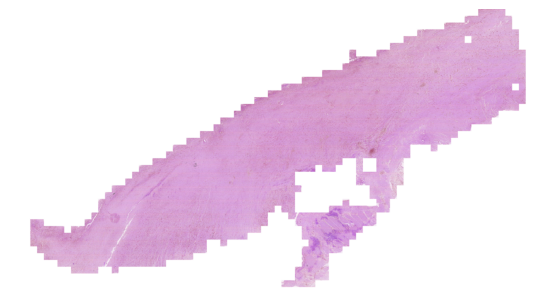

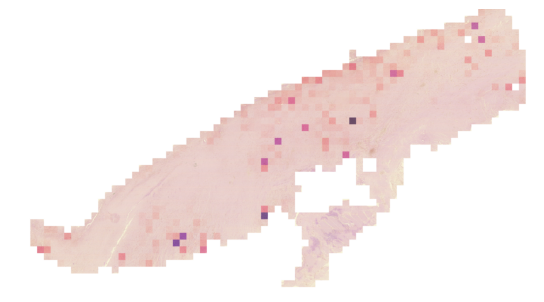

In [70]:
def apply_mask(image, mask, color, alpha=0.5):
    for c in range(3):
        image[:, :, c] = image[:, :, c] * (1 - alpha * mask) + alpha * mask * color[c] * 255
    return image


# Get tile information.
def get_x_y(tile_info):
    if '.' in str(tile_info):
        string = tile_info.split('.')[0]
    else:
        string = str(tile_info)
    # if TCGA-MESO put - instead of _.
    x, y   = string.split('_')
    return int(x),int(y)
    
def get_wsi_arrays(frame, attention_scores, slide, img_size, downsample, img_dicts):
    slide_indices  = frame[frame[matching_field]==slide].indexes.values.tolist()
    slide_tiles    = frame[frame[matching_field]==slide].tiles.values.tolist()
    slide_sets     = frame[frame[matching_field]==slide].original_set.values.tolist()
    # attention_scores = frame[frame[matching_field]==slide].attention_scores.values.tolist()
    # give random attention scores to the tiles 
    # attention_scores = np.random.rand(len(slide_tiles)).tolist()
    clr_plt = sns.color_palette("magma_r", as_cmap=True)
    color_map = clr_plt(attention_scores)

    y,x = get_x_y(slide_tiles[0])
    x_min = x
    x_max = x
    y_min = y
    y_max = y
    for i in slide_tiles:
        y_i, x_i  = get_x_y(i)
        x_min = min(x_min, x_i)
        y_min = min(y_min, y_i)
        x_max = max(x_max, x_i)
        y_max = max(y_max, y_i)
    x_max += 1
    y_max += 1

    wsi_x = int(x_max*img_size//downsample)
    wsi_y = int(y_max*img_size//downsample)

    # Original 5x.
    wsi   = np.ones((wsi_x, wsi_y, 3), dtype=np.uint8)*255
    wsi_c = np.ones((wsi_x, wsi_y, 3), dtype=np.uint8)*255
    print('\t\tWhole Slide Image Resolution %s: (%s, %s)' % (slide, wsi_x, wsi_y))

    for index, tile, original_set, attention_score, color in zip(slide_indices, slide_tiles, slide_sets, attention_scores, color_map):
        y_i, x_i  = get_x_y(tile)
        x_i *= img_size//downsample
        y_i *= img_size//downsample
        tile_img = img_dicts[original_set][int(index)]
        tile_img = np.array(resize(tile_img, (tile_img.shape[0]//downsample, tile_img.shape[1]//downsample), anti_aliasing=True), dtype=float)
        tile_img = (tile_img*255).astype(np.uint8)     
        
        mask  = np.ones((img_size//downsample,img_size//downsample))

        wsi[x_i:x_i+(img_size//downsample), y_i:y_i+(img_size//downsample), :]   = tile_img
        wsi_c[x_i:x_i+(img_size//downsample), y_i:y_i+(img_size//downsample), :] = apply_mask(tile_img, mask, color, alpha=0.5)

    return wsi, wsi_c


case_Id = 'MESO_8_16'
matching_field = 'slides'

# Get the attention scores for the specific case
temp = frame[frame['slides']==case_Id].iloc[:,0:128].values
temp_tnsr = torch.from_numpy(temp).resize(1,temp.shape[0],1,temp.shape[1])
model.eval()
y_hat, y_prob, attention_scores, weighted_instances = model(temp_tnsr)
att = attention_scores.squeeze(0).squeeze(0).detach().numpy()
att_transformed = (att - np.min(att)) / (np.max(att) - np.min(att))
# att = att / att.max()
# att_transformed = np.log1p(att * 1e5)  # Boost and compress

# OR
# att_transformed = np.power(att, 0.2)  # Gamma correction style

wsi, wsi_c = get_wsi_arrays(frame, att_transformed, case_Id, img_size=224, downsample=5, img_dicts=data_dicts)

for wsi_ in [wsi, wsi_c]:
    dpi = 500
    height, width, _ = wsi_.shape
    figsize = width / float(dpi), height / float(dpi)
    fig = plt.figure(figsize=figsize)
    ax  = fig.add_subplot(1, 1, 1) 
    ax.imshow(wsi_/255.)
    ax.axis('off')
    plt.show(fig)
    # plt.savefig(f'{figure_path}/trans_meso/{wsi_name}_{case_Id}.png', bbox_inches='tight', dpi=dpi)
    plt.close(fig)